# Preparing a state with antiferromagnetic order in the Ising model

This notebook illustrates how to use Pulser to build a sequence for studying an antiferromagnetic state in an Ising-like model. It is based on [10.1103/PhysRevX.8.021070](https://journals.aps.org/prx/abstract/10.1103/PhysRevX.8.021070), where arrays of Rydberg atoms were programmed and whose correlations were studied.

We begin by importing some basic modules:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qutip

from pulser import Pulse, Sequence, Register
from pulser_simulation import QutipEmulator
from pulser.waveforms import RampWaveform
from pulser.devices import Chadoq2

## Waveforms 

We are realizing the following program

<center>
<img src="attachment:AF_Ising_program.png" alt="AF Pulse Sequence" width="300">
</center>

The pulse and the register are defined by the following parameters:

Interatomic Radius is: 9.756753962298905µm.


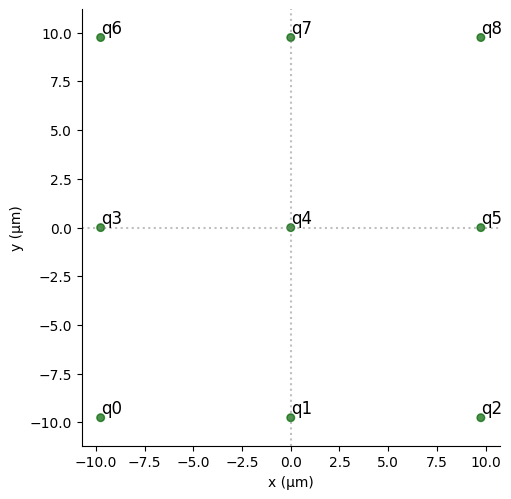

In [2]:
# Parameters in rad/µs and ns
Omega_max = 2.3 * 2 * np.pi
U = Omega_max / 2.3

delta_0 = -6 * U
delta_f = 2 * U

t_rise = 252
t_fall = 500
t_sweep = (delta_f - delta_0) / (2 * np.pi * 10) * 1000

R_interatomic = Chadoq2.rydberg_blockade_radius(U)

N_side = 3
reg = Register.square(N_side, R_interatomic, prefix="q")
print(f"Interatomic Radius is: {R_interatomic}µm.")
reg.draw()

## Creating my sequence

We compose our pulse with the following objects from Pulser:

In [10]:
rise = Pulse.ConstantDetuning(
    RampWaveform(t_rise, 0.0, Omega_max), delta_0, 0.0
)
sweep = Pulse.ConstantAmplitude(
    Omega_max, RampWaveform(t_sweep, delta_0, 0.0), 0.0
)
fall = Pulse.ConstantDetuning(
    RampWaveform(t_fall, Omega_max, 0.0), delta_f, 0.0
)

In [11]:
from pulser.waveforms import InterpolatedWaveform

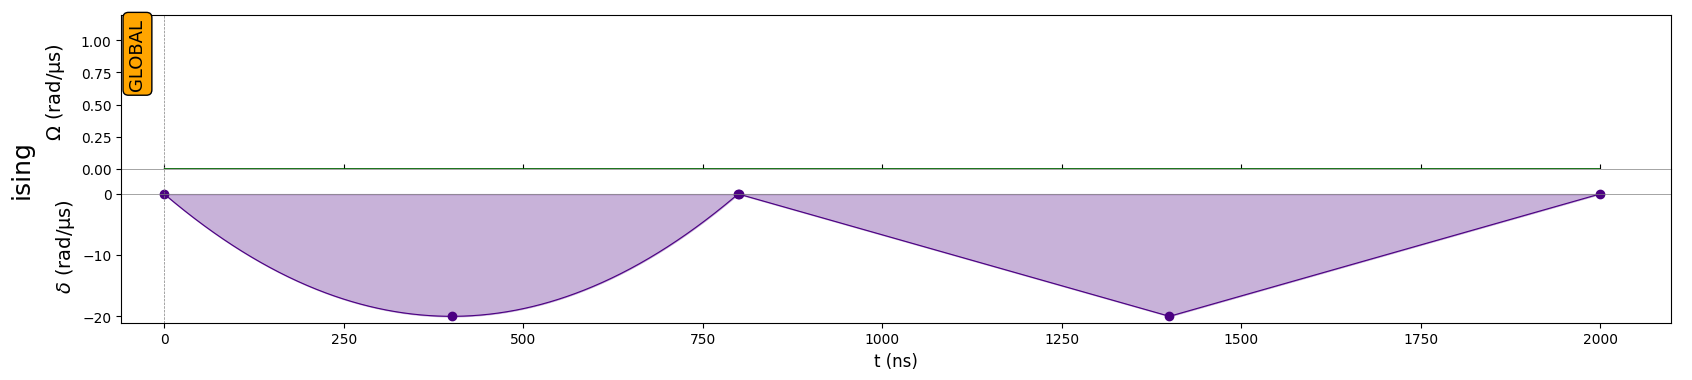

In [16]:
seq = Sequence(reg, Chadoq2)
seq.declare_channel("ising", "rydberg_global")

seq.add(
    Pulse.ConstantAmplitude(
        0,
        InterpolatedWaveform(
            800,
            [0, -20, 0],
            [0, 0.5, 1.0],
        ),
        0.0,
    ),
    "ising",
)
seq.add(
    Pulse.ConstantAmplitude(
        0,
        InterpolatedWaveform(1200, [0, -20, 0], [0, 0.5, 1.0], "interp1d"),
        0.0,
    ),
    "ising",
)

seq.draw()

## Phase Diagram

The pulse sequence travels though the following path in the phase diagram of the system (the shaded area represents the antiferromagnetic phase):

In [ ]:
delta = []
omega = []
for x in seq._schedule["ising"]:
    if isinstance(x.type, Pulse):
        omega += list(x.type.amplitude.samples / U)
        delta += list(x.type.detuning.samples / U)

fig, ax = plt.subplots()
ax.grid(True, which="both")

ax.set_ylabel(r"$\hbar\delta(t)/U$", fontsize=16)
ax.set_xlabel(r"$\hbar\Omega(t)/U$", fontsize=16)
ax.set_xlim(0, 3)
ax.axhline(y=0, color="k")
ax.axvline(x=0, color="k")

y = np.arange(0.0, 6, 0.01)
x = 1.522 * (1 - 0.25 * (y - 2) ** 2)
ax.fill_between(x, y, alpha=0.4)

ax.plot(omega, delta, "red", lw=2)
plt.show()

## Simulation: Spin-Spin Correlation Function

We shall now evaluate the quality of the obtained state by calculating the *spin-spin correlation function*, defined as:


$$g^c(k,l)= \frac{1}{N_{k,l}}\sum_{(i,j) = (kR,lR)} \left[ \langle n_i n_j \rangle - \langle n_i \rangle \langle n_j \rangle \right]$$

where the $c$ indicates that we are calculating the *connected* part, and where the sum is over all pairs $(i,j)$ whose distance is ${\bf r}_i - {\bf r}_j = (k R,l R)$ in the atomic array coordinate (both $k$ and $l$ are positive or negative integers within the size of the array).

We run a simulation of the sequence:

In [ ]:
simul = QutipEmulator.from_sequence(seq, sampling_rate=0.02)
results = simul.run(progress_bar=True)

Sample from final state using `sample_final_state()` method:

In [ ]:
count = results.sample_final_state()

most_freq = {k: v for k, v in count.items() if v > 10}
plt.bar(list(most_freq.keys()), list(most_freq.values()))
plt.xticks(rotation="vertical")
plt.show()

The observable to measure will be the occupation operator $|r\rangle \langle r|_i$ on each site $i$ of the register, where the Rydberg state $|r\rangle$ represents the excited state.

In [ ]:
def occupation(j, N):
    up = qutip.basis(2, 0)
    prod = [qutip.qeye(2) for _ in range(N)]
    prod[j] = up * up.dag()
    return qutip.tensor(prod)

In [ ]:
occup_list = [occupation(j, N_side * N_side) for j in range(N_side * N_side)]

We define a function that returns all couples $(i,j)$ for a given $(k,l)$:

In [ ]:
def get_corr_pairs(k, l, register, R_interatomic):
    corr_pairs = []
    for i, qi in enumerate(register.qubits):
        for j, qj in enumerate(register.qubits):
            r_ij = register.qubits[qi] - register.qubits[qj]
            distance = np.linalg.norm(r_ij - R_interatomic * np.array([k, l]))
            if distance < 1:
                corr_pairs.append([i, j])
    return corr_pairs

The correlation function is calculated with the following routines:

In [ ]:
def get_corr_function(k, l, reg, R_interatomic, state):
    N_qubits = len(reg.qubits)
    corr_pairs = get_corr_pairs(k, l, reg, R_interatomic)

    operators = [occupation(j, N_qubits) for j in range(N_qubits)]
    covariance = 0
    for qi, qj in corr_pairs:
        covariance += qutip.expect(operators[qi] * operators[qj], state)
        covariance -= qutip.expect(operators[qi], state) * qutip.expect(
            operators[qj], state
        )
    return covariance / len(corr_pairs)


def get_full_corr_function(reg, state):
    N_qubits = len(reg.qubits)

    correlation_function = {}
    N_side = int(np.sqrt(N_qubits))
    for k in range(-N_side + 1, N_side):
        for l in range(-N_side + 1, N_side):
            correlation_function[(k, l)] = get_corr_function(
                k, l, reg, R_interatomic, state
            )
    return correlation_function

With these functions, we operate on the final state of evolution obtained by our simulation.

In [ ]:
final = results.states[-1]
correlation_function = get_full_corr_function(reg, final)

In [ ]:
expected_corr_function = {}
xi = 1  # Estimated Correlation Length
for k in range(-N_side + 1, N_side):
    for l in range(-N_side + 1, N_side):
        kk = np.abs(k)
        ll = np.abs(l)
        expected_corr_function[(k, l)] = (-1) ** (kk + ll) * np.exp(
            -np.sqrt(k**2 + l**2) / xi
        )

In [ ]:
A = 4 * np.reshape(
    list(correlation_function.values()), (2 * N_side - 1, 2 * N_side - 1)
)
A = A / np.max(A)
B = np.reshape(
    list(expected_corr_function.values()), (2 * N_side - 1, 2 * N_side - 1)
)
B = B * np.max(A)

for i, M in enumerate([A.copy(), B.copy()]):
    M[N_side - 1, N_side - 1] = None
    plt.figure(figsize=(3.5, 3.5))
    plt.imshow(M, cmap="coolwarm", vmin=-0.6, vmax=0.6)
    plt.xticks(range(len(M)), [f"{x}" for x in range(-N_side + 1, N_side)])
    plt.xlabel(r"$\mathscr{k}$", fontsize=22)
    plt.yticks(range(len(M)), [f"{-y}" for y in range(-N_side + 1, N_side)])
    plt.ylabel(r"$\mathscr{l}$", rotation=0, fontsize=22, labelpad=10)
    plt.colorbar(fraction=0.047, pad=0.02)
    if i == 0:
        plt.title(
            r"$4\times\.g^{(2)}(\mathscr{k},\mathscr{l})$ after simulation",
            fontsize=14,
        )
    if i == 1:
        plt.title(
            r"Exponential $g^{(2)}(\mathscr{k},\mathscr{l})$ expected",
            fontsize=14,
        )
    plt.show()

Note that the correlation function would follow an exponential decay (modulo finite-size effects), which is best observed at larger system sizes (see for example https://arxiv.org/pdf/2012.12268.pdf)

In [ ]:
np.around(A, 4)

In [ ]:
np.around(B, 4)

### Néel Structure Factor

One way to explore the $\Omega = 0$ line on the phase diagram is to calculate the *Néel Structure Factor*, $S_{\text{Néel}}=4 \times \sum_{(k,l) \neq (0,0)} (-1)^{|k|+|l|} g^c(k,l)$, which should be highest when the state is more antiferromagnetic. We will sweep over different values of $\delta_{\text{final}}$ to show that the region $0<\hbar \delta_{\text{final}}/U<4$ is indeed where the antiferromagnetic phase takes place.

In [ ]:
def get_neel_structure_factor(reg, R_interatomic, state):
    N_qubits = len(reg.qubits)
    N_side = int(np.sqrt(N_qubits))

    st_fac = 0
    for k in range(-N_side + 1, N_side):
        for l in range(-N_side + 1, N_side):
            kk = np.abs(k)
            ll = np.abs(l)
            if not (k == 0 and l == 0):
                st_fac += (
                    4
                    * (-1) ** (kk + ll)
                    * get_corr_function(k, l, reg, R_interatomic, state)
                )
    return st_fac

In [ ]:
def calculate_neel(det, N, Omega_max=2.3 * 2 * np.pi):
    # Setup:
    U = Omega_max / 2.3
    delta_0 = -6 * U
    delta_f = det * U

    t_rise = 252
    t_fall = 500
    t_sweep = int((delta_f - delta_0) / (2 * np.pi * 10) * 1000)
    t_sweep += (
        4 - t_sweep % 4
    )  # To be a multiple of the clock period of Chadoq2 (4ns)

    R_interatomic = Chadoq2.rydberg_blockade_radius(U)
    reg = Register.rectangle(N, N, R_interatomic)

    # Pulse Sequence
    rise = Pulse.ConstantDetuning(
        RampWaveform(t_rise, 0.0, Omega_max), delta_0, 0.0
    )
    sweep = Pulse.ConstantAmplitude(
        Omega_max, RampWaveform(t_sweep, delta_0, delta_f), 0.0
    )
    fall = Pulse.ConstantDetuning(
        RampWaveform(t_fall, Omega_max, 0.0), delta_f, 0.0
    )

    seq = Sequence(reg, Chadoq2)
    seq.declare_channel("ising", "rydberg_global")
    seq.add(rise, "ising")
    seq.add(sweep, "ising")
    seq.add(fall, "ising")

    simul = QutipEmulator.from_sequence(seq, sampling_rate=0.2)
    results = simul.run()

    final = results.states[-1]
    return get_neel_structure_factor(reg, R_interatomic, final)

In [ ]:
N_side = 3
occup_list = [occupation(j, N_side * N_side) for j in range(N_side * N_side)]

detunings = np.linspace(-1, 5, 20)
results = []
for det in detunings:
    print(f"Detuning = {np.round(det,3)} x 2π Mhz.")
    results.append(calculate_neel(det, N_side))
plt.xlabel(r"$\hbar\delta_{final}/U$")
plt.ylabel(r"Néel Structure Factor $S_{Neel}$")
plt.plot(detunings, results, "o", ls="solid")
plt.show()
max_index = results.index(max(results))
print(
    f"Max S_Neel {np.round(max(results),2)} at detuning = {np.round(detunings[max_index],2)} x 2π Mhz."
)